### Duolingo Subscription User Persona Investigation and Analysis
#### Shiyu Liu
#### shiyuliu001@gmail.com

In [147]:
# Linear Algebra and DF
import pandas as pd
import numpy as np
from collections import Counter

# EDA, Visualization
import matplotlib
from matplotlib import pylab as plt
plt.style.use("seaborn")
import seaborn as sns
from  matplotlib.ticker import PercentFormatter


# Missing value imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor


# Encoder and Scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

## Feature Selection
from sklearn.feature_selection import f_classif, mutual_info_classif

## Warning
import warnings
warnings.filterwarnings("ignore")


## ML Models
from sklearn.linear_model import LogisticRegression
from scipy import stats
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

import catboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score


from sklearn.metrics import confusion_matrix

In [148]:
! ls

Data Science Take Home Task - Data Dictionary.xlsx
Data_Scientist_-_Take_Home_Task_(November_2019).pdf
Duolingo_THT.ipynb
survey_data.csv
survey_users_app_usage.csv
~$Data Science Take Home Task - Data Dictionary.xlsx


## 0 Dataset Import, Preprocessing and Cleaning

#### User Usage Dataset

In [149]:
user_usage = pd.read_csv("survey_users_app_usage.csv")

In [150]:
user_usage['took_placement_test'].unique()

array([True, False, nan], dtype=object)

In [151]:
user_usage = pd.read_csv("survey_users_app_usage.csv")

#### Feature and value cleaning


user_usage['user_id'] = user_usage['user_id'].astype('str')
# Use 2018-12-31(survey time at the end of 2018) as enddate to calculate the time since start
user_usage['duolingo_start_date'] = (pd.to_datetime("2018-12-31") - 
                                     pd.to_datetime(user_usage['duolingo_start_date'])).dt.days.astype('Int64')

user_usage['took_placement_test'].fillna(False, inplace=True) # Fill those with no record as False, 19 observations
user_usage['took_placement_test'] = user_usage['took_placement_test'].astype('bool')
user_usage = user_usage[user_usage['n_days_on_platform']>0]
user_usage['highest_crown_count'].fillna(0) # Fill those with no crown value as zero, 292 counts
user_usage.columns = ['user_id', 'days_to_year_end', 'daily_goal',
       'highest_course_progress', 'took_placement_test',
       'purchased_subscription', 'highest_crown_count', 'n_active_days',
       'n_lessons_started', 'n_lessons_completed', 'longest_streak',
       'n_days_on_platform']

In [152]:
user_usage.head()

,user_id,days_to_year_end,daily_goal,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
0,35cb7e8f72c911e9888edca9049399ef,193,NaN,46.0,True,False,277.0,88,741.0,668.0,135,137
1,35ca34fd72c911e99ed6dca9049399ef,509,NaN,50.0,True,False,62.0,16,57.0,57.0,6,453
2,35d1a54a72c911e98e25dca9049399ef,1537,1.0,71.0,False,False,202.0,29,315.0,295.0,55,1481
3,35d4beb072c911e9aa92dca9049399ef,86,NaN,2.0,False,False,2.0,3,6.0,5.0,1,30
4,35ccf4bd72c911e9be2edca9049399ef,1200,NaN,34.0,False,False,216.0,57,338.0,297.0,56,1144


#### Dealing with Missing value in usage dataset: multivariate imputation with random forest regressor

In [153]:
user_usage_impute = user_usage.copy()[['user_id', 'days_to_year_end', 'daily_goal',
       'highest_course_progress', 'took_placement_test',
       'purchased_subscription', 'highest_crown_count', 'n_active_days',
       'n_lessons_started', 'n_lessons_completed', 'longest_streak',
       'n_days_on_platform']]

In [154]:
X = user_usage_impute[['days_to_year_end', 'daily_goal',
       'highest_course_progress', 'took_placement_test', 'highest_crown_count', 'n_active_days',
       'n_lessons_started', 'n_lessons_completed', 'longest_streak',
       'n_days_on_platform']].values
print(X[:5])

imputer = IterativeImputer(estimator=RandomForestRegressor(),random_state=1000)
X_impute = imputer.fit_transform(X)

print(X_impute[:5])
user_usage_impute[['days_to_year_end', 'daily_goal',
       'highest_course_progress', 'took_placement_test', 'highest_crown_count', 'n_active_days',
       'n_lessons_started', 'n_lessons_completed', 'longest_streak',
       'n_days_on_platform']] = X_impute

[[193 nan 46.0 True 277.0 88 741.0 668.0 135 137]
 [509 nan 50.0 True 62.0 16 57.0 57.0 6 453]
 [1537 1.0 71.0 False 202.0 29 315.0 295.0 55 1481]
 [86 nan 2.0 False 2.0 3 6.0 5.0 1 30]
 [1200 nan 34.0 False 216.0 57 338.0 297.0 56 1144]]
[[1.930e+02 4.800e+01 4.600e+01 1.000e+00 2.770e+02 8.800e+01 7.410e+02
  6.680e+02 1.350e+02 1.370e+02]
 [5.090e+02 2.500e+01 5.000e+01 1.000e+00 6.200e+01 1.600e+01 5.700e+01
  5.700e+01 6.000e+00 4.530e+02]
 [1.537e+03 1.000e+00 7.100e+01 0.000e+00 2.020e+02 2.900e+01 3.150e+02
  2.950e+02 5.500e+01 1.481e+03]
 [8.600e+01 2.200e+01 2.000e+00 0.000e+00 2.000e+00 3.000e+00 6.000e+00
  5.000e+00 1.000e+00 3.000e+01]
 [1.200e+03 2.400e+01 3.400e+01 0.000e+00 2.160e+02 5.700e+01 3.380e+02
  2.970e+02 5.600e+01 1.144e+03]]


In [155]:
user_usage_impute

,user_id,days_to_year_end,daily_goal,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
0,35cb7e8f72c911e9888edca9049399ef,193.0,48.0,46.0,1.0,False,277.0,88.0,741.0,668.0,135.0,137.0
1,35ca34fd72c911e99ed6dca9049399ef,509.0,25.0,50.0,1.0,False,62.0,16.0,57.0,57.0,6.0,453.0
2,35d1a54a72c911e98e25dca9049399ef,1537.0,1.0,71.0,0.0,False,202.0,29.0,315.0,295.0,55.0,1481.0
3,35d4beb072c911e9aa92dca9049399ef,86.0,22.0,2.0,0.0,False,2.0,3.0,6.0,5.0,1.0,30.0
4,35ccf4bd72c911e9be2edca9049399ef,1200.0,24.0,34.0,0.0,False,216.0,57.0,338.0,297.0,56.0,1144.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6144,35cc559972c911e9a65ddca9049399ef,995.0,20.0,-5.0,0.0,False,17.0,9.0,74.0,73.0,3.0,939.0
6145,35d0323a72c911e9bc0ddca9049399ef,1767.0,18.2,-4.0,0.0,False,35.0,23.0,70.0,68.0,21.0,1711.0
6146,35cbcbb572c911e9807ddca9049399ef,1193.0,21.0,-5.0,0.0,False,52.2,27.0,29.0,58.0,2.0,1137.0
6147,35cffde372c911e9b4afdca9049399ef,196.0,20.0,-3.0,0.0,False,19.0,94.0,192.0,185.0,44.0,140.0


#### Survey Dataset

In [156]:
survey = pd.read_csv("survey_data.csv")
survey.columns

Index(['user_id', 'age', 'annual_income', 'country', 'duolingo_platform',
       'duolingo_subscriber', 'duolingo_usage', 'employment_status',
       'future_contact', 'gender', 'other_resources',
       'primary_language_commitment', 'primary_language_review',
       'primary_language_motivation', 'primary_language_motivation_followup',
       'primary_language_proficiency', 'student', 'survey_complete',
       'time_spent_seconds'],
      dtype='object')

In [157]:
survey['duolingo_subscriber'].unique()

array(['No, I have never paid for Duolingo Plus',
       'Yes, I currently pay for Duolingo Plus',
       'No, but I have previously paid for Duolingo Plus',
       "I don't know if I pay for Duolingo Plus", nan], dtype=object)

In [158]:


############# Features Cleaning ############
## Age
survey['age'] = survey['age'].replace(['18-34', '35 - 54', 'Under 18', '55 - 74', '75 or older'],
                                     ['18-34', '35-54', '<18', '55-74', '>75'])
## Annual Income
survey['annual_income'] = survey['annual_income'].replace(['$26,000 - $75,000', '$76,000 - $150,000', '$0 - $10,000',
                                                           '$151,000 or more', '$11,000 - $25,000'], 
                                                          ['26,000-75,000', '76,000-150,000', '<10,000',
                                                           '>151,000', '11,000-25,000'])
## Platform
survey['duolingo_platform'] = survey['duolingo_platform'].replace(['Android phone or tablet', 'iPhone or iPad', 'Web browser'],
                                                                 ['Android', 'Apple', 'Browser'])
## Subscribe
survey['duolingo_subscriber'] = survey['duolingo_subscriber'].replace(['No, I have never paid for Duolingo Plus',
                                                                       'Yes, I currently pay for Duolingo Plus',
                                                                       'No, but I have previously paid for Duolingo Plus',
                                                                       "I don't know if I pay for Duolingo Plus"],
                                                                       ["Never", "Yes","Previously", "IDK"])
survey['duolingo_subscriber'] = survey['duolingo_subscriber'].fillna("IDK")

## Usage
survey['duolingo_usage'] = survey['duolingo_usage'].replace(["Less than once a month", "I don't use Duolingo"],
                                                           ["<1 a month", "Never"])
## Employment
survey['employment_status'] = survey['employment_status'].replace(['Employed full-time', 'Employed part-time', 'Unemployed'],
                                                                ['Full-time', 'Part-time', 'Unemployed'])
## Commitment
survey['primary_language_commitment'] = survey['primary_language_commitment'].replace(["I'm very committed to learning this language.",
                                                                                       "I'm slightly committed to learning this language.",
                                                                                       "I'm moderately committed to learning this language.",
                                                                                       "I'm extremely committed to learning this language.",
                                                                                       "I'm not at all committed to learning this language."],
                                                                                     ["Very", "Slightly", "Moderately", "Extremely", "Not"])
survey['primary_language_review'] = survey['primary_language_review'].replace(["I am using Duolingo to review a language I've studied before.",
                                                                               'I am using Duolingo to learn this language for the first time.'],
                                                                              ['Review', "Learn"])
## Motivation
survey['primary_language_motivation'] = survey['primary_language_motivation'].replace(['I like to learn new languages',
                                                                                       'I need to be able to speak the local language where I live',
                                                                                       'I want to connect with my heritage or identity',
                                                                                       'I am preparing for a trip',
                                                                                       'I want to use my time more productively',
                                                                                       'I want to challenge myself',
                                                                                       'I want my family to learn a language together',
                                                                                       'I want to improve relationships with some of the people in my life',
                                                                                       'I am interested in a culture that speaks this language',
                                                                                       'I want to advance professionally or economically',
                                                                                       'I need to learn this language for school',
                                                                                       'I want to keep my brain healthy',
                                                                                       "I don't want to forget what I've previously learned"], 
                                                                                      ["Learn", "Speak locally", "Heritage", "Trip", "Time-using", "Challenge", "Falimly-learn",
                                                                                       "Relationship-improving", "Culture", "Profession advance", "School Learn", "Brain-health",
                                                                                       "Prevent forgetting"])
## Student
survey['student'] = survey['student'].replace(['Not currently a student', 'Part-time student','Full-time student'], ["Not", "Part-time", "Full-time"])
survey.columns = ['user_id', 'age', 'annual_income', 'country', 'platform',
                   'subscriber', 'usage', 'employment', 'future_contact', 'gender', 'other_resources',
                   'commitment', 'review','motivation', 'motivation_followup',
                   'primary_language_proficiency', 'student', 'survey_complete','time']
# survey = survey[['user_id', 'age', 'annual_income', 'country', 'platform',
#                    'subscriber', 'usage', 'employment', 'future_contact', 'gender',
#                    'commitment', 'review','motivation',
#                    'primary_language_proficiency', 'student', 'survey_complete','time']]
survey[['age', 'annual_income', 'country', 'platform',
                   'usage', 'employment', 'future_contact', 'gender', 'other_resources',
                   'commitment', 'review','motivation', 'motivation_followup',
                   'primary_language_proficiency', 'student', 'survey_complete','time']] = survey[['age', 'annual_income', 'country', 'platform',
                   'usage', 'employment', 'future_contact', 'gender', 'other_resources',
                   'commitment', 'review','motivation', 'motivation_followup',
                   'primary_language_proficiency', 'student', 'survey_complete','time']].fillna("Not Specified")

In [522]:
survey

,user_id,age,annual_income,country,platform,subscriber,usage,employment,future_contact,gender,other_resources,commitment,review,motivation,motivation_followup,primary_language_proficiency,student,survey_complete,time
0,35c9fc6e72c911e99681dca9049399ef,18-34,"26,000-75,000",JP,Android,Never,Daily,Full-time,Yes,Male,"Stories/novels/children's books,Movies/TV Shows",Very,Review,Learn,"I want to learn as many languages as I can,Oth...",Advanced,Not,1,193
1,35c9fdde72c911e98630dca9049399ef,18-34,"26,000-75,000",JP,Apple,Never,Weekly,Full-time,Yes,Male,Not Specified,Slightly,Review,Speak locally,"I am an immigrant,I am a refugee",Intermediate,Not,1,139
2,35c9feb072c911e9ab4cdca9049399ef,18-34,"76,000-150,000",JP,Apple,Yes,Daily,Full-time,Yes,Male,Not Specified,Moderately,Review,Heritage,Not Specified,Beginner,Not,1,119
3,35c9ff7072c911e9900ddca9049399ef,18-34,"76,000-150,000",JP,Apple,Previously,Daily,Full-time,Yes,Female,Other apps,Very,Learn,Trip,I want to learn some basics in the local langu...,Intermediate,Not,1,229
4,35ca002672c911e99effdca9049399ef,35-54,"76,000-150,000",JP,Android,Yes,Daily,Full-time,Yes,Male,Not Specified,Very,Learn,Heritage,Not Specified,Intermediate,Not,1,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6182,35cfd79c72c911e9a397dca9049399ef,35-54,"26,000-75,000",GB,Apple,Never,Daily,Full-time,Yes,Male,Online language class,Very,Learn,Heritage,Not Specified,Beginner,Not,1,-293
6183,35d2f08a72c911e9b7dbdca9049399ef,35-54,Not Specified,CO,Android,Never,Daily,Full-time,Yes,Male,Not Specified,Very,Review,Learn,It's been a lifelong goal to learn this langua...,Beginner,Not,1,-222
6184,35cd250f72c911e9b9a1dca9049399ef,55-74,">151,000",GB,Apple,Never,Never,Full-time,No,Female,"Stories/novels/children's books,Movies/TV Show...",Extremely,Review,Profession advance,Learning this language will help me get a bett...,Beginner,Full-time,1,-114
6185,35cf7a1772c911e9b029dca9049399ef,55-74,"26,000-75,000",FR,Android,Yes,Daily,Retired,No,Male,Not Specified,Very,Review,Brain-health,Not Specified,Beginner,Not,1,-284


## 1 Data Exploration

In this section, the main works are focused on the relationship between features and purchased_subscription

In [160]:
survey_usage = user_usage_impute.merge(survey, on="user_id", how="inner")
survey_usage = survey_usage.sort_values('n_days_on_platform')
survey_usage.drop_duplicates(subset='user_id', keep='last', inplace=True)
survey_usage = survey_usage.reset_index()
survey_usage
# survey_usage[survey_usage.duplicated(subset="user_id", keep=False)]

,index,user_id,days_to_year_end,daily_goal,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,n_lessons_started,...,gender,other_resources,commitment,review,motivation,motivation_followup,primary_language_proficiency,student,survey_complete,time
0,5240,35d47eb372c911e9bbdbdca9049399ef,58.0,19.0,23.0,0.0,False,38.0,3.0,32.0,...,Male,"Textbooks,In-person language class",Very,Review,Heritage,Not Specified,Beginner,Not,1,530
1,463,35d6c75972c911e9b929dca9049399ef,58.0,30.0,4.0,0.0,False,7.0,3.0,32.0,...,Not Specified,Not Specified,Not Specified,Not Specified,Not Specified,Not Specified,Not Specified,Not Specified,0,45
2,1565,35cb1e4f72c911e9b2e9dca9049399ef,58.0,19.0,21.0,1.0,False,38.0,3.0,25.0,...,Male,In-person language class,Extremely,Learn,Speak locally,"I am an immigrant,I am a refugee",Intermediate,Not,1,239
3,1264,35cbe24072c911e997dedca9049399ef,58.0,35.0,2.0,0.0,False,1.0,2.0,12.0,...,Male,Movies/TV Shows,Very,Learn,Speak locally,"I am an immigrant,I am an expat",Beginner,Not Specified,1,346
4,2351,35cbfce372c911e99728dca9049399ef,58.0,50.0,12.0,0.0,False,54.0,3.0,467.0,...,Female,Movies/TV Shows,Very,Review,Brain-health,Not Specified,Intermediate,Full-time,1,253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,5792,35cefa2172c911e994d1dca9049399ef,2437.0,41.0,38.0,1.0,True,332.0,86.0,291.0,...,Male,"Other apps,Textbooks,Stories/novels/children's...",Extremely,Learn,Profession advance,Learning this language will be useful in my cu...,Intermediate,Part-time,1,5172
6075,1382,35cf13f372c911e98d09dca9049399ef,2438.0,12.4,31.0,1.0,True,80.0,37.0,138.0,...,Male,"Textbooks,Online language class,Other (please ...",Very,Review,Trip,I want to communicate with locals in a meaning...,Beginner,Not,1,353
6076,3217,35cebcfd72c911e9ab23dca9049399ef,2445.0,10.0,27.0,0.0,True,101.0,94.0,99.0,...,Male,"Other apps,Textbooks,Stories/novels/children's...",Very,Review,Trip,I want to show respect by speaking the local l...,Intermediate,Not,1,575
6077,5236,35cf9a5c72c911e9a30bdca9049399ef,2456.0,50.0,64.0,0.0,True,210.0,89.0,296.0,...,Female,Not Specified,Extremely,Review,Brain-health,Not Specified,Advanced,Not,1,143


#### Proportion of subscribed users

Number of users subscribing:  1916
Number of users not subscribing:  4163


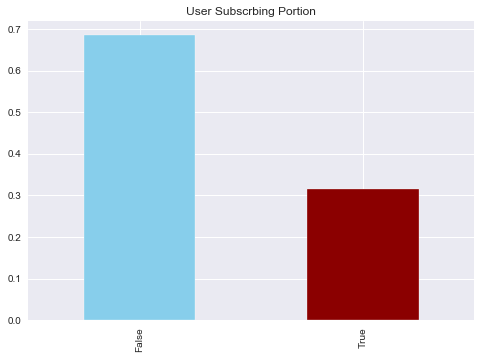

In [161]:
print("Number of users subscribing: ", survey_usage[survey_usage['purchased_subscription'] == 1].shape[0])
print("Number of users not subscribing: ", survey_usage[survey_usage['purchased_subscription'] == 0].shape[0])
sub_frac = survey_usage['purchased_subscription'].value_counts()/survey_usage['purchased_subscription'].shape[0]
sub_frac.plot(kind='bar', stacked=True,color=("skyblue", "darkred"))
plt.title('User Subscrbing Portion')
plt.show()

In [162]:
survey_usage.columns

Index(['index', 'user_id', 'days_to_year_end', 'daily_goal',
       'highest_course_progress', 'took_placement_test',
       'purchased_subscription', 'highest_crown_count', 'n_active_days',
       'n_lessons_started', 'n_lessons_completed', 'longest_streak',
       'n_days_on_platform', 'age', 'annual_income', 'country', 'platform',
       'subscriber', 'usage', 'employment', 'future_contact', 'gender',
       'other_resources', 'commitment', 'review', 'motivation',
       'motivation_followup', 'primary_language_proficiency', 'student',
       'survey_complete', 'time'],
      dtype='object')

In [163]:
num_cols = ['daily_goal','highest_course_progress', 'highest_crown_count', 'n_active_days', 'n_lessons_started', 'n_lessons_completed',
           'longest_streak', 'n_days_on_platform']
cat_cols = ['took_placement_test', 'age', 'annual_income', 'country', 'platform', 'subscriber', 'usage', 'employment',
           'future_contact', 'gender', 'commitment', 'review', 'motivation', 'primary_language_proficiency',
           'student', 'survey_complete']
cat_cols_nosub = ['took_placement_test', 'age', 'annual_income', 'country', 'platform', 'usage', 'employment',
           'future_contact', 'gender', 'commitment', 'review', 'motivation', 'primary_language_proficiency',
           'student', 'survey_complete']

user_buy = user_usage[user_usage['purchased_subscription']==1]
user_not_buy = user_usage[user_usage['purchased_subscription']==0]

#### Numerical Variable and Subscription Status


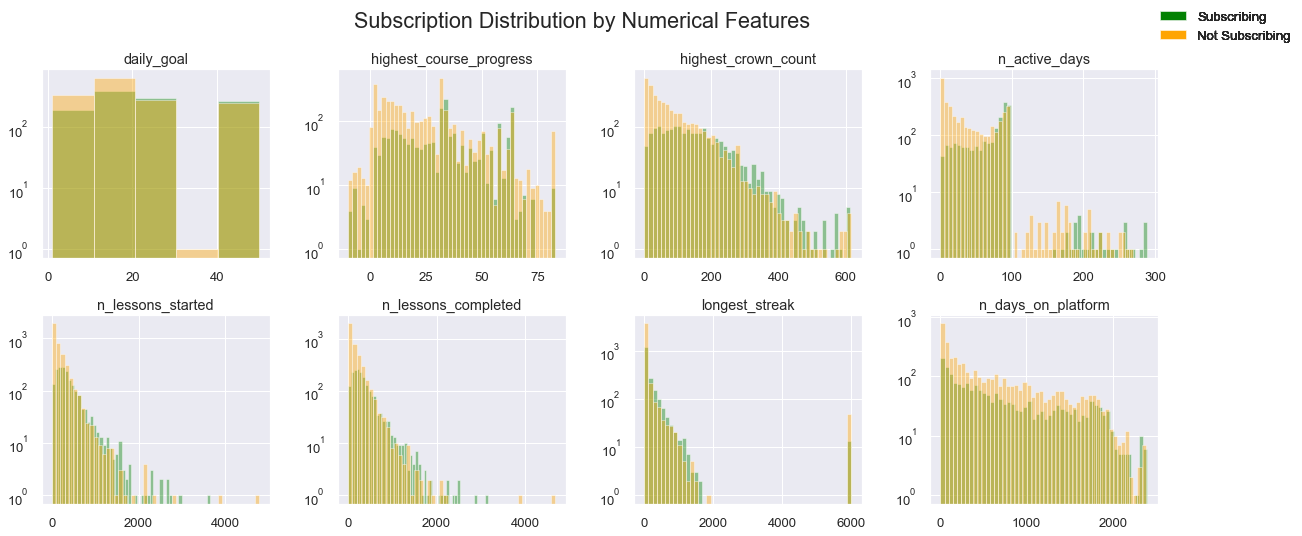

In [587]:
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(20,8))
r = 0
c = 0
fig.suptitle("Subscription Distribution by Numerical Features")
for var in num_cols:
    if c == 0 and r == 0:
        user_buy.hist(var, bins = 5, ax=axes[r,c], color = "green",alpha=0.4,label="Subscribing", log=True)
        user_not_buy.hist(var, bins = 5, ax=axes[r,c], color = "orange",alpha=0.4,label="Not Subscribing", log=True)
    else:
        user_buy.hist(var, bins = 50, ax=axes[r,c], color = "green",alpha=0.4,log=True)
        user_not_buy.hist(var, bins = 50, ax=axes[r,c], color = "orange",alpha=0.4,log=True)
    if c != 3:
        c += 1
    else:
        r += 1
        c = 0
    fig.legend()



#### Categorical variables and Subscription Status

In [165]:
sns.set(font_scale=1.2)

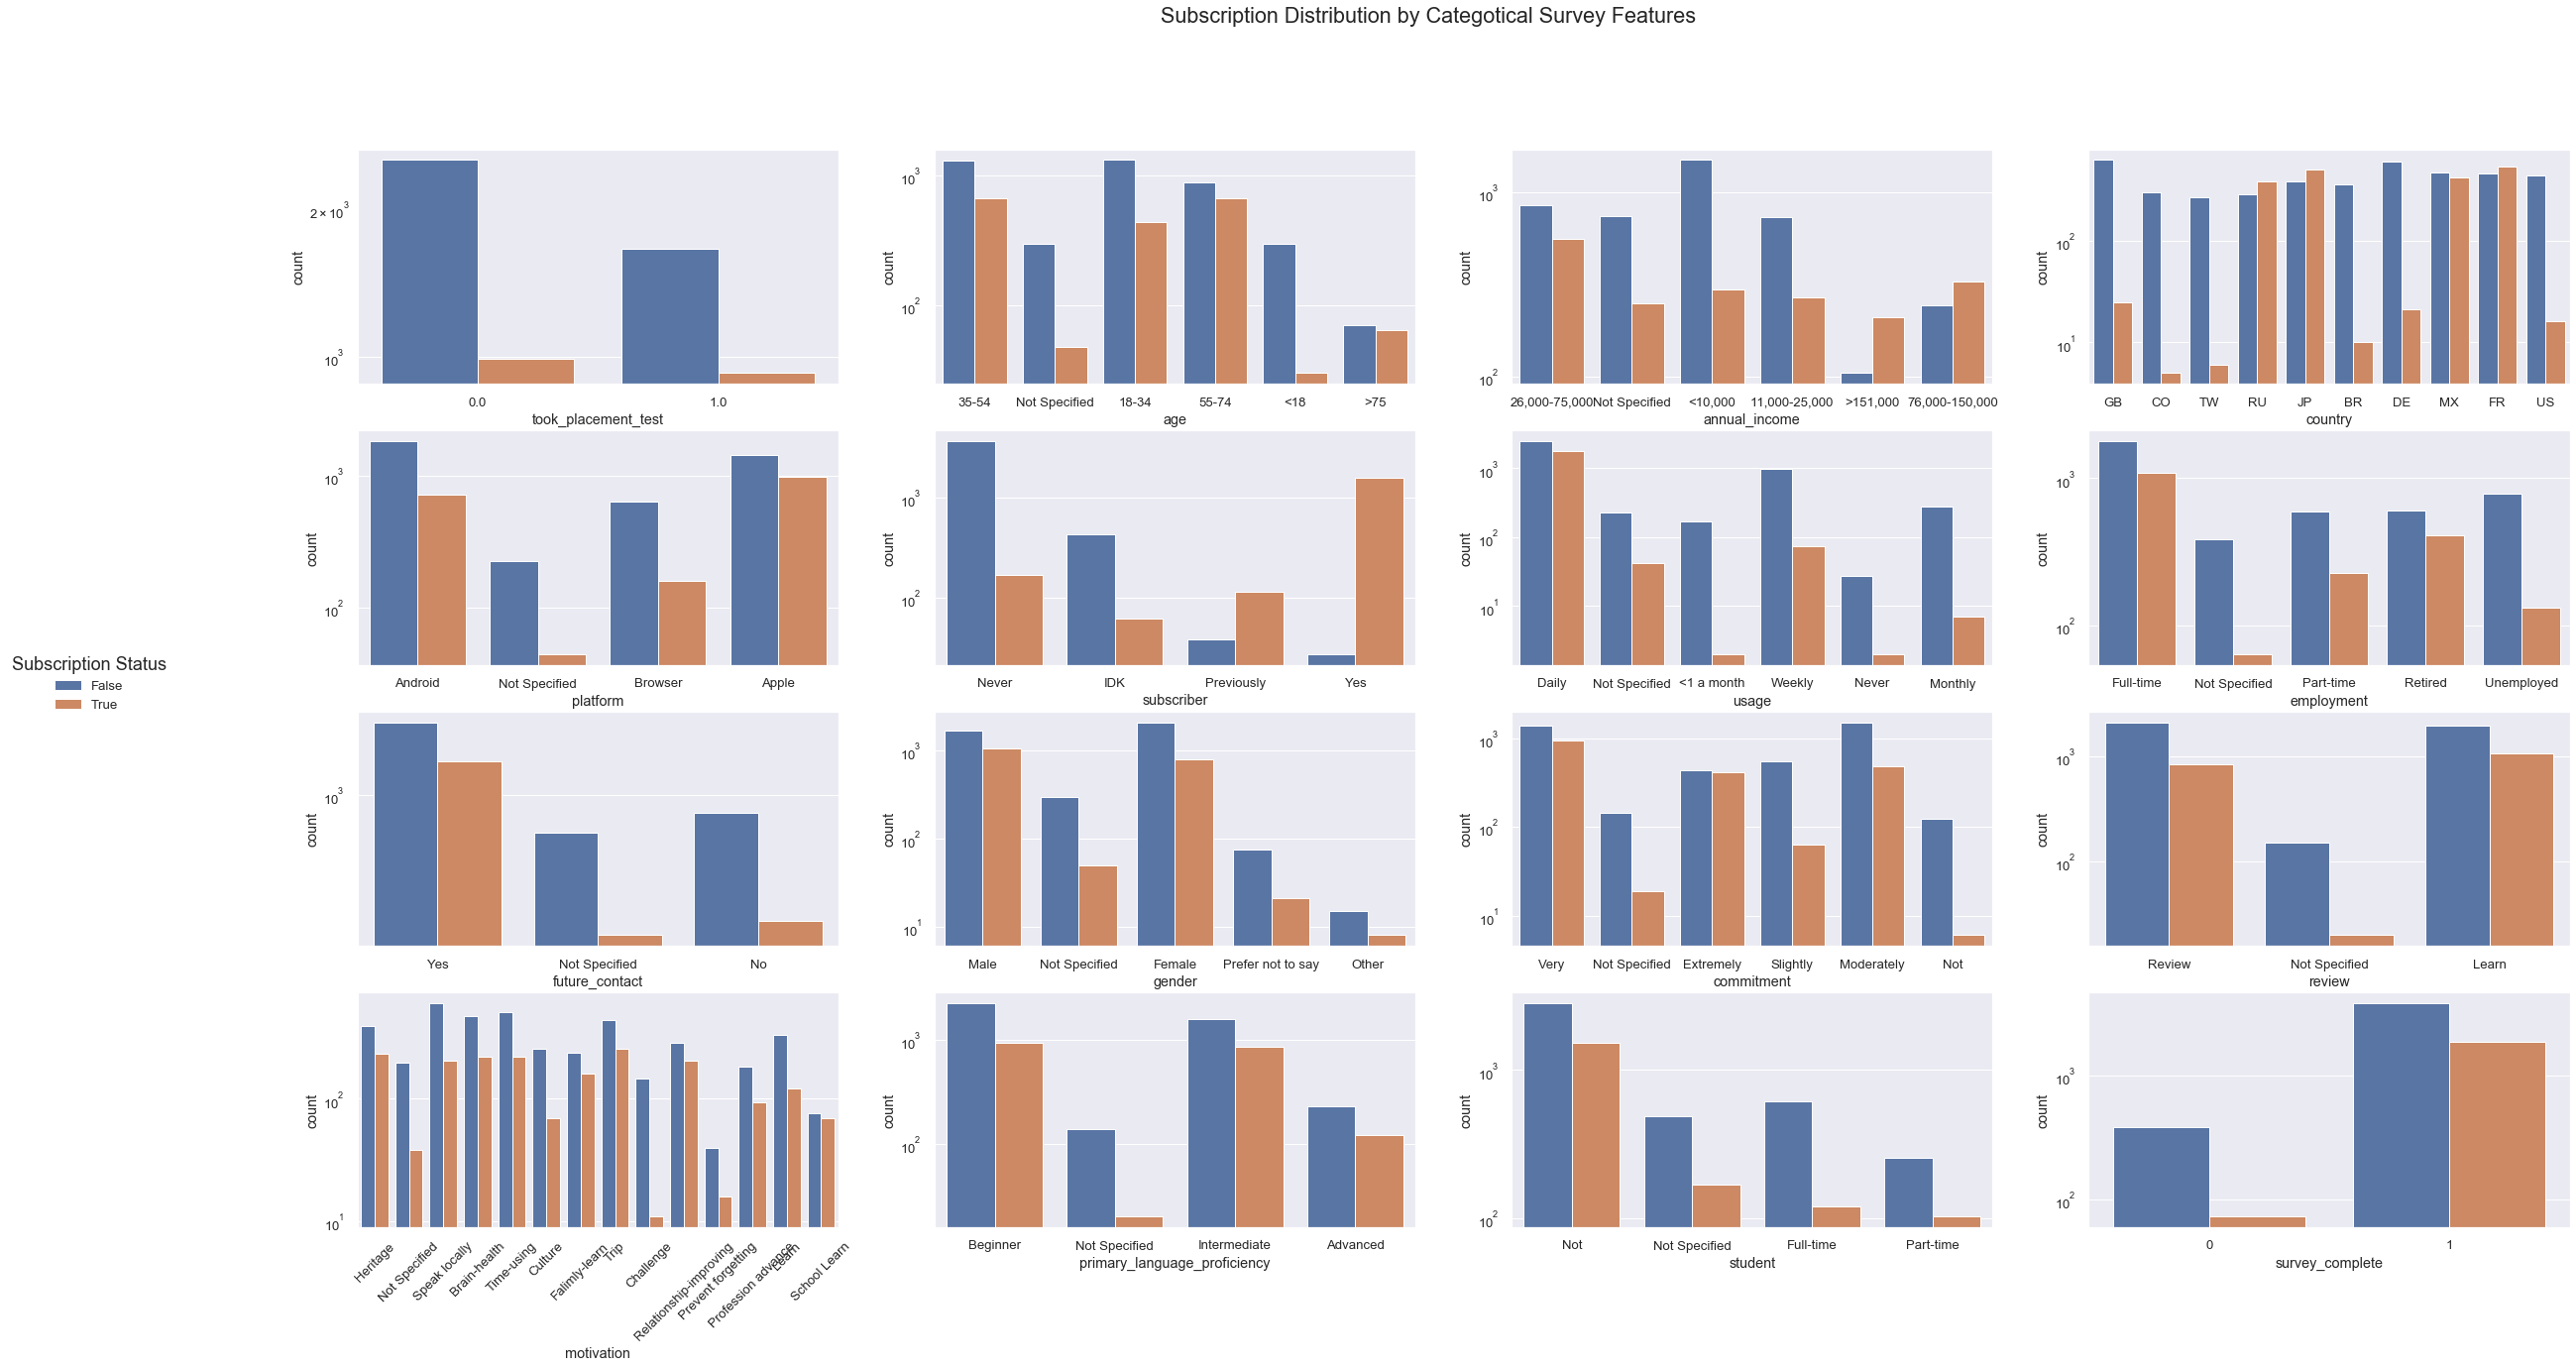

In [588]:
plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(nrows=4, ncols=4,figsize=(40,20))

r = 0
c = 0
for var in cat_cols:
    sns.catplot(x=var, kind="count", hue="purchased_subscription", data=survey_usage, ax=axes[r,c], legend=False)
    axes[r,c].get_legend().set_visible(False)
    axes[r,c].set_yscale("log")
    if var == "motivation":
        axes[r,c].set_xticklabels(axes[r,c].xaxis.get_majorticklabels(), rotation=45)
    if r == c == 0:
        fig.legend(loc='center left', title='Subscription Status')
    if c != 3:
        c += 1
    else:
        r += 1
        c = 0

for i in range(2,18):
    plt.close(i)
fig.suptitle("Subscription Distribution by Categotical Survey Features")
plt.show()

Subscription History Distribution by Categotical Survey Features


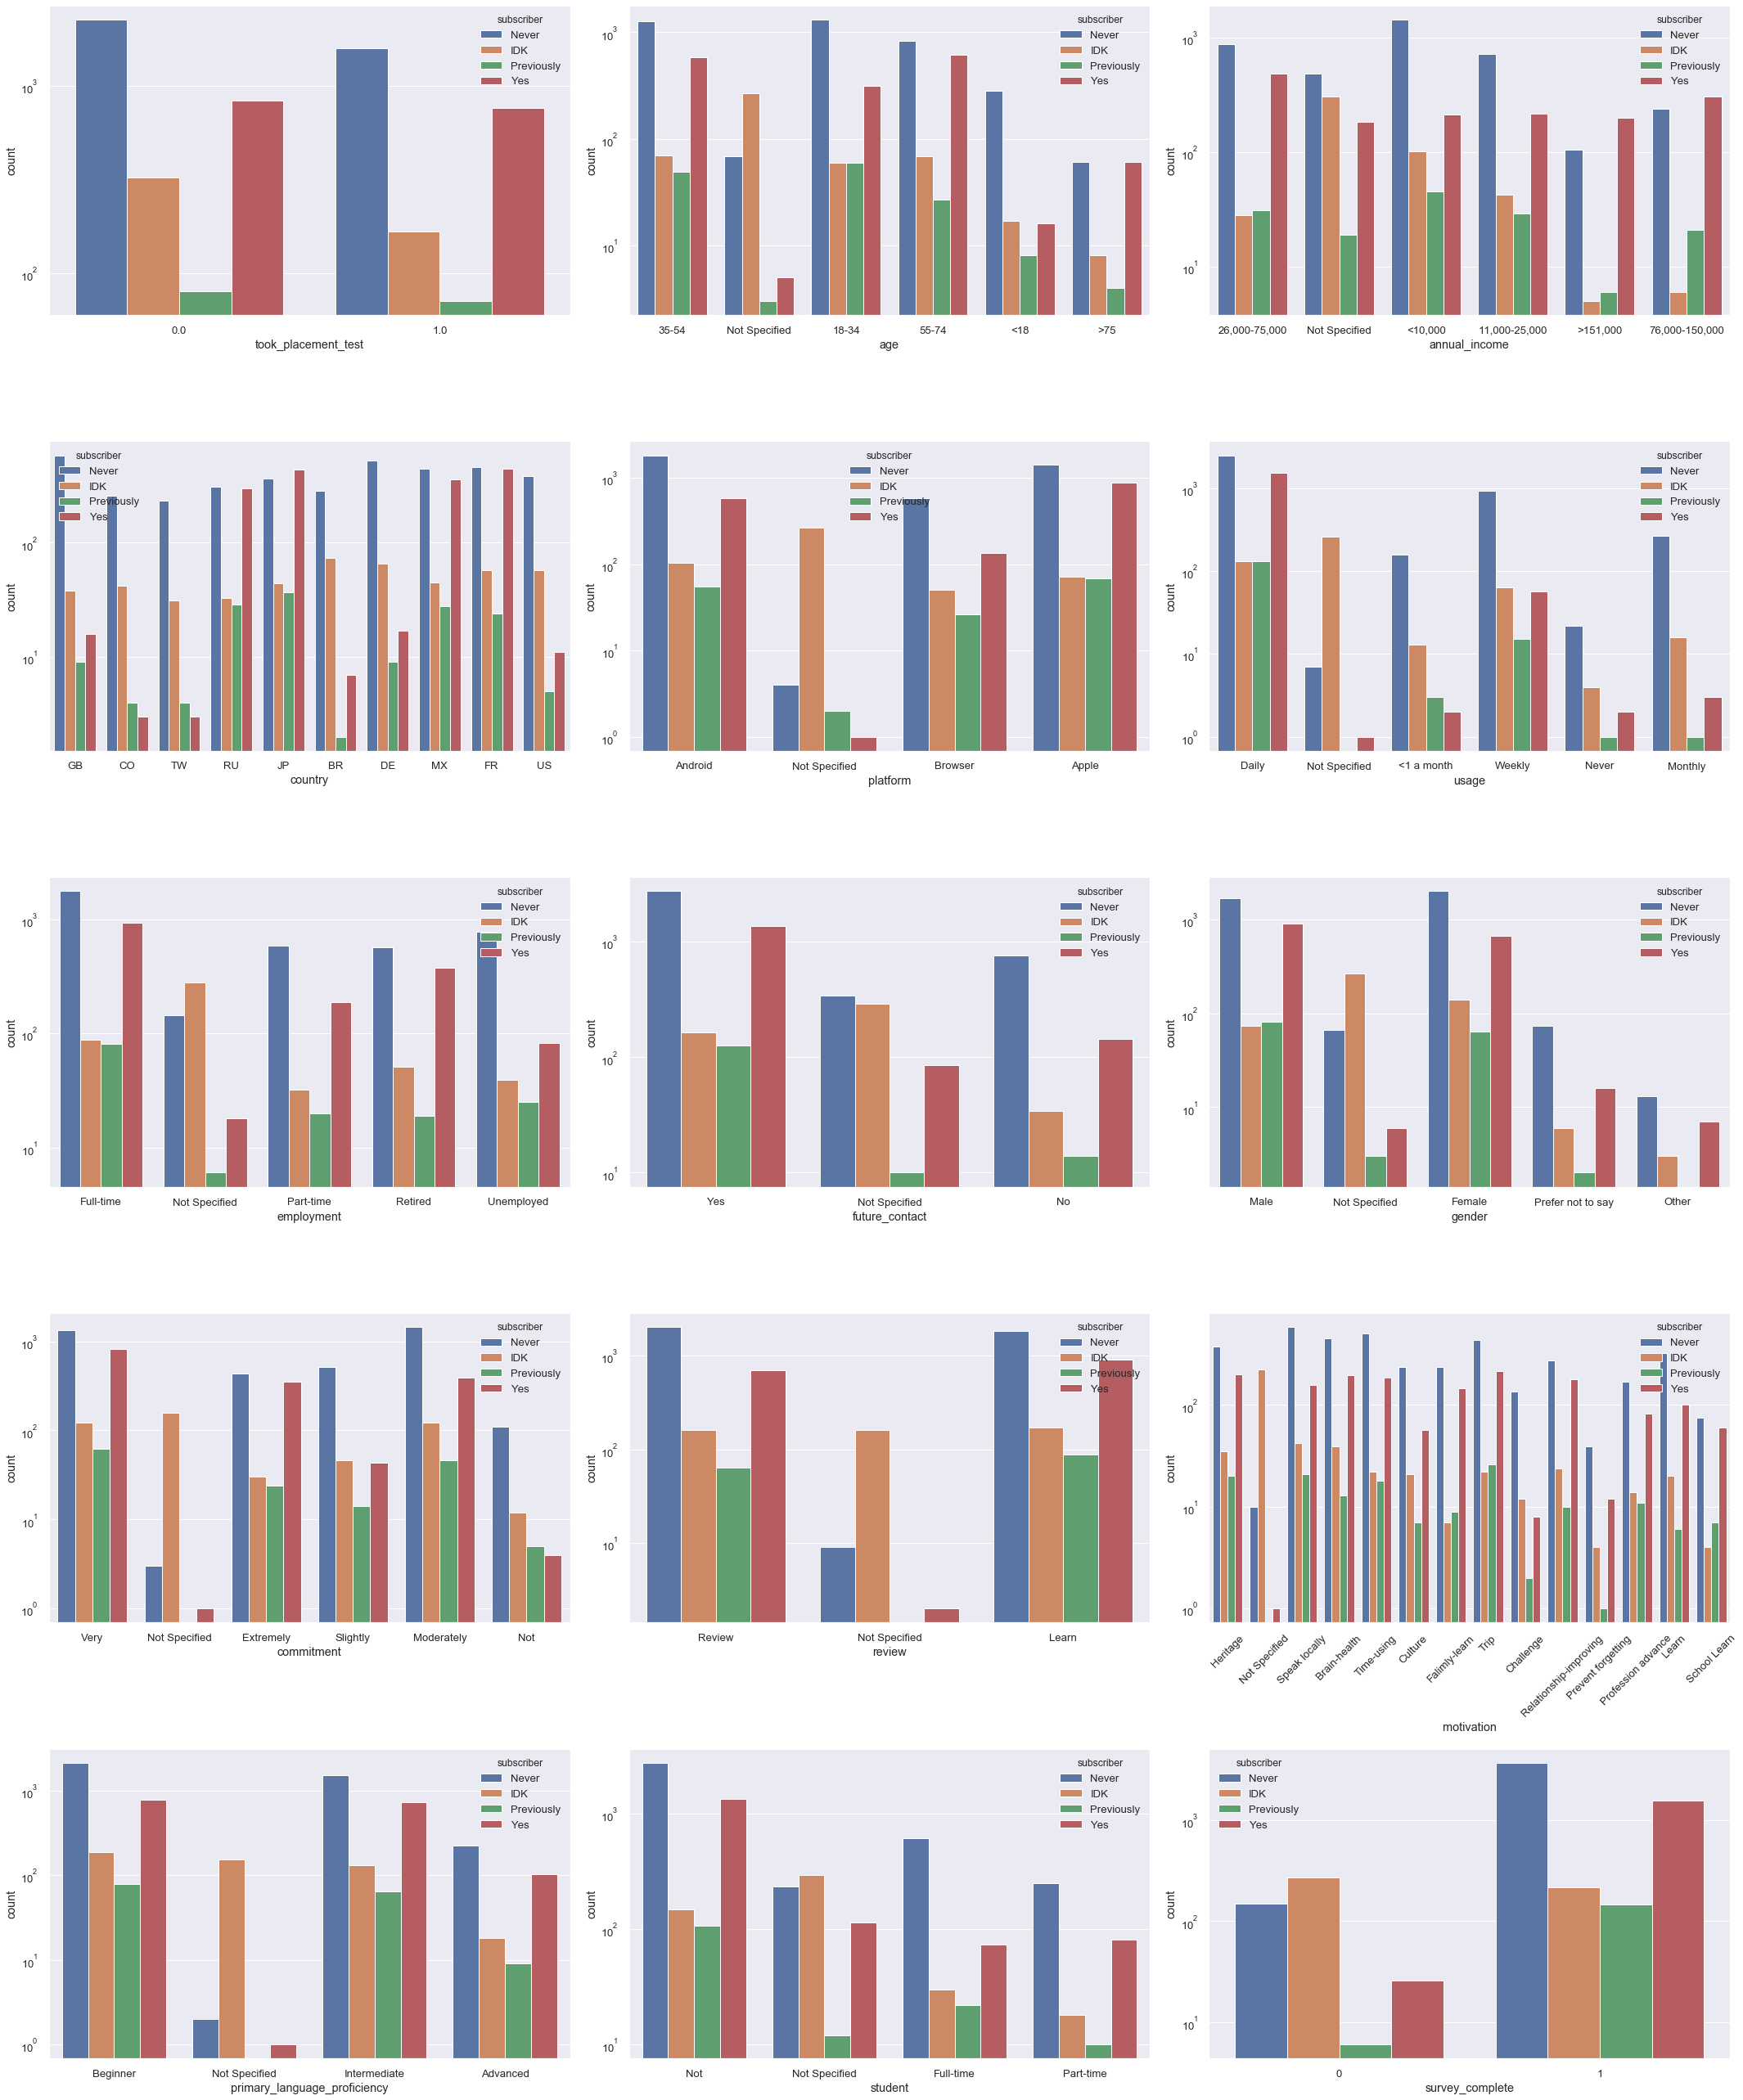

In [592]:
plt.rcParams.update({'font.size': 18})
print("Subscription History Distribution by Categotical Survey Features")
fig, axes = plt.subplots(nrows=5, ncols=3,figsize=(30,36))

r = 0
c = 0
for var in cat_cols_nosub:
    sns.catplot(x=var, kind="count", hue="subscriber", data=survey_usage, ax=axes[r,c], legend=True, log=False)
    # axes[r,c].get_legend().set_visible(False)
    if var == "motivation":
        axes[r,c].set_xticklabels(axes[r,c].xaxis.get_majorticklabels(), rotation=45)
    axes[r,c].set_yscale("log")
    if r == c == 0:
        pass
        # fig.legend(loc='upper left', title='Subscription Intention')
    if c != 2:
        c += 1
    else:
        r += 1
        c = 0

for i in range(2,18):
    plt.close(i)

plt.tight_layout()
plt.show()

## 2 Quantitatively Identify User Segments/Personas

### Correlation Matrix Calculation and Visualization

#### Numerical usage features

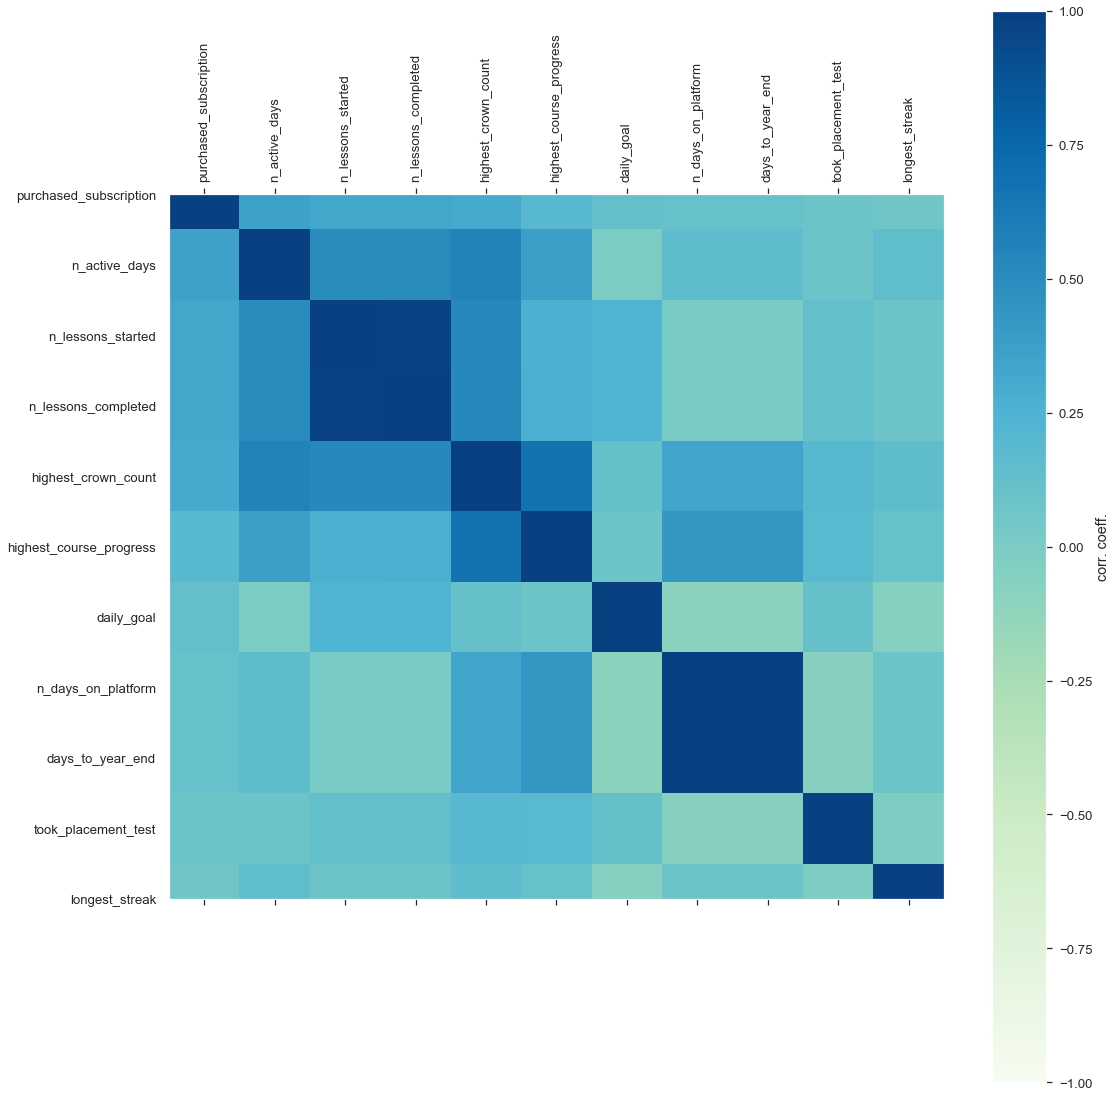

In [564]:
plt.rcParams["axes.grid"] = False
corrmat = user_usage.corr()
plt.rcParams.update({'font.size': 10})
all_cols = corrmat.abs().sort_values('purchased_subscription',ascending=False)['purchased_subscription'].index 
cols = all_cols
cm_order1 = corrmat.loc[cols,cols]

plt.figure(figsize=(16,16))
plt.matshow(cm_order1,cmap="GnBu",fignum=0,vmin=-1, vmax=1)
plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(cm_order1.shape[0]),list(cols),rotation=90)
plt.yticks(np.arange(cm_order1.shape[0]),list(cols))
plt.tight_layout() 
plt.show()
plt.rcParams.update({'font.size': 10})

#### One-hot Encoder to quantitative categorical features

In [567]:
# one-hot encoder for categorical variables
oh_cols = ['age', 'annual_income', 'country', 'platform', 'usage', 'employment',
           'future_contact', 'gender', 'commitment', 'review', 'motivation', 'primary_language_proficiency',
           'student']

ohe = OneHotEncoder(sparse=False)
cat_values = ohe.fit_transform(survey_usage[oh_cols])
cat_ftr_names1 = ohe.get_feature_names(oh_cols)
df_cat = pd.DataFrame(data=cat_values,columns = cat_ftr_names1)

survey_usage_onehot = pd.concat([survey_usage[num_cols], df_cat, survey_usage[['took_placement_test','purchased_subscription','survey_complete', 'subscriber']]], axis=1)


In [568]:
## Label Encoder subscriber
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
survey_usage_onehot['subscriber'] = le.fit_transform(survey_usage_onehot['subscriber'])
subscriber_temp = survey_usage_onehot['subscriber']

In [569]:
# Check Class Assignment
le.transform(['Never', 'Yes', 'Previously', 'IDK'])

array([1, 3, 2, 0])

In [570]:
survey_usage_onehot

,daily_goal,highest_course_progress,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform,age_18-34,age_35-54,...,primary_language_proficiency_Intermediate,primary_language_proficiency_Not Specified,student_Full-time,student_Not,student_Not Specified,student_Part-time,took_placement_test,purchased_subscription,survey_complete,subscriber
0,19.0,23.0,38.0,3.0,32.0,30.0,2.0,2.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,1,1
1,30.0,4.0,7.0,3.0,32.0,31.0,3.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,False,0,0
2,19.0,21.0,38.0,3.0,25.0,25.0,3.0,2.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,False,1,1
3,35.0,2.0,1.0,2.0,12.0,5.0,1.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,1,1
4,50.0,12.0,54.0,3.0,467.0,401.0,4.0,2.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,False,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,41.0,38.0,332.0,86.0,291.0,293.0,6000.0,2381.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,True,1,3
6075,12.4,31.0,80.0,37.0,138.0,133.0,35.0,2382.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,1,3
6076,10.0,27.0,101.0,94.0,99.0,93.0,421.0,2389.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,True,1,3
6077,50.0,64.0,210.0,89.0,296.0,292.0,246.0,2400.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True,1,3


#### Top n(40) Features Having High Correlation with Subscription Status

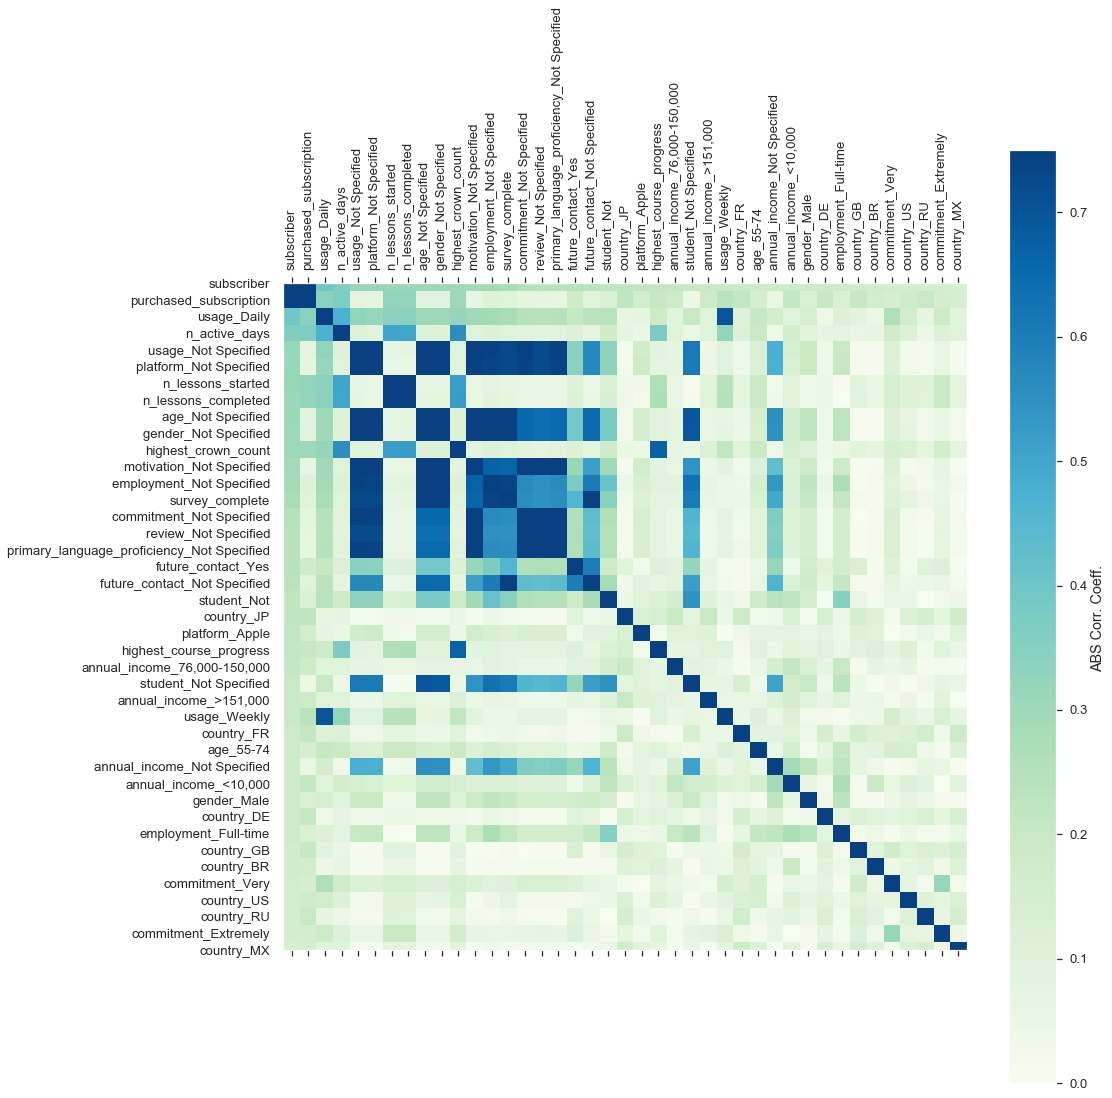

In [571]:
nfeature = 41
corrmat = survey_usage_onehot.corr().abs()
plt.rcParams.update({'font.size': 10})
all_cols = corrmat.abs().sort_values('subscriber',ascending=False)['subscriber'].index 
cols = all_cols
cm_order2 = corrmat.loc[cols[:nfeature],cols[:nfeature]]

plt.figure(figsize=(16,16))
plt.matshow(cm_order2,cmap="GnBu",fignum=0,vmin=0, vmax=0.75)
plt.colorbar(label='ABS Corr. Coeff. ')
plt.xticks(np.arange(cm_order2.shape[0]),list(cols),rotation=90)
plt.yticks(np.arange(cm_order2.shape[0]),list(cols))
plt.tight_layout() 
plt.show()
plt.rcParams.update({'font.size': 10})
survey_usage_onehot = survey_usage_onehot.drop('subscriber', axis=1)

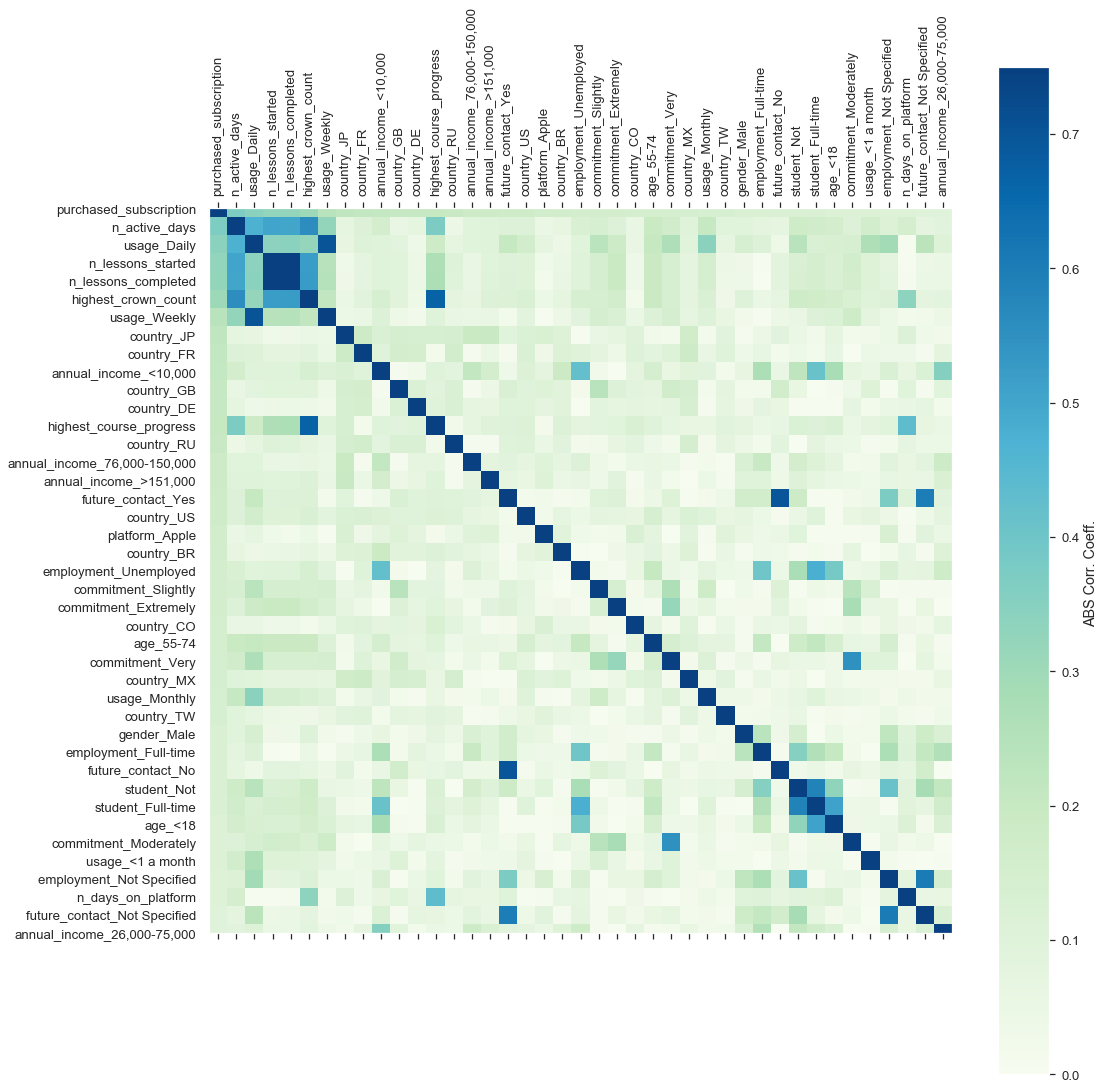

In [574]:

nfeature = 41
corrmat = survey_usage_onehot.corr().abs()
plt.rcParams.update({'font.size': 10})
all_cols = corrmat.abs().sort_values('purchased_subscription',ascending=False)['purchased_subscription'].index 
cols = all_cols
cm_order2 = corrmat.loc[cols[:nfeature],cols[:nfeature]]

plt.figure(figsize=(16,16))
plt.matshow(cm_order2,cmap="GnBu",fignum=0,vmin=0, vmax=0.75)
plt.colorbar(label='ABS Corr. Coeff. ')
plt.xticks(np.arange(cm_order2.shape[0]),list(cols),rotation=90)
plt.yticks(np.arange(cm_order2.shape[0]),list(cols))
plt.tight_layout() 
plt.show()
plt.rcParams.update({'font.size': 10})

In [295]:

corrmat = survey_usage_onehot.corr()
corrmat_index = corrmat.abs().sort_values('purchased_subscription',ascending=False)['purchased_subscription'].index
corrmat.loc[cols[:nfeature],cols[:nfeature]]

,purchased_subscription,n_active_days,usage_Daily,n_lessons_started,n_lessons_completed,highest_crown_count,usage_Weekly,country_JP,country_FR,"annual_income_<10,000",...,future_contact_No,student_Not,student_Full-time,age_<18,commitment_Moderately,usage_<1 a month,employment_Not Specified,n_days_on_platform,future_contact_Not Specified,"annual_income_26,000-75,000"
purchased_subscription,1.000000,0.366547,0.342440,0.325630,0.323822,0.304546,-0.239944,0.221608,0.210552,-0.206210,...,-0.125949,0.124112,-0.121269,-0.114012,-0.112954,-0.112208,-0.104623,0.102756,-0.099499,0.095817
n_active_days,0.366547,1.000000,0.471280,0.501152,0.499099,0.558229,-0.322714,0.073174,0.107840,-0.149682,...,-0.067547,0.175649,-0.166733,-0.152449,-0.108033,-0.157761,-0.114128,0.148769,-0.077041,0.088423
usage_Daily,0.342440,0.471280,1.000000,0.338081,0.341457,0.321210,-0.702422,0.065588,0.100235,-0.096315,...,-0.040242,0.237827,-0.123912,-0.131613,-0.132048,-0.263730,-0.290133,-0.003117,-0.229506,0.103712
n_lessons_started,0.325630,0.501152,0.338081,1.000000,0.982720,0.519648,-0.240975,0.031811,0.074870,-0.097532,...,-0.083842,0.123229,-0.144426,-0.117275,-0.156208,-0.103574,-0.073334,0.006487,-0.043953,0.047205
n_lessons_completed,0.323822,0.499099,0.341457,0.982720,1.000000,0.524159,-0.243889,0.032830,0.075138,-0.099328,...,-0.084385,0.129091,-0.146641,-0.118314,-0.154795,-0.103434,-0.080100,0.010481,-0.051240,0.050932
highest_crown_count,0.304546,0.558229,0.321210,0.519648,0.524159,1.000000,-0.216082,0.049528,0.089239,-0.135884,...,-0.070560,0.172463,-0.168013,-0.155169,-0.127664,-0.098938,-0.111070,0.334416,-0.077745,0.079978
usage_Weekly,-0.239944,-0.322714,-0.702422,-0.240975,-0.243889,-0.216082,1.000000,-0.043642,-0.049856,0.109121,...,0.044257,-0.052832,0.107980,0.115661,0.170543,-0.078482,-0.042381,0.019400,-0.024586,-0.044755
country_JP,0.221608,0.073174,0.065588,0.031811,0.032830,0.049528,-0.043642,1.000000,-0.181691,-0.124608,...,-0.088235,0.051821,0.025055,0.068342,-0.020029,-0.028633,-0.042793,0.109864,-0.030085,0.024417
country_FR,0.210552,0.107840,0.100235,0.074870,0.075138,0.089239,-0.049856,-0.181691,1.000000,-0.094728,...,0.021219,-0.037596,-0.020244,-0.063313,-0.002111,-0.041038,-0.037555,-0.037367,-0.009814,0.076409
"annual_income_<10,000",-0.206210,-0.149682,-0.096315,-0.097532,-0.099328,-0.135884,0.109121,-0.124608,-0.094728,1.000000,...,0.057071,-0.223504,0.412242,0.279511,0.069343,0.057859,-0.124285,-0.066019,-0.115790,-0.355811


### F-score and Mutual Information Score Calculation

In [296]:
# F score
f_order = list(cm_order2.index[1:])
f_order

suo_X = survey_usage_onehot.drop(["purchased_subscription"],axis=1)
suo_Y = survey_usage_onehot["purchased_subscription"]
f_test, p_values = f_classif(suo_X,suo_Y)
names = list(suo_X.columns)
f_temp = pd.DataFrame([f_test])
f_temp.columns = names
f_inorder = pd.DataFrame()
for feature in f_order:
    f_inorder[feature] = f_temp[feature]
f_inorder

,n_active_days,usage_Daily,n_lessons_started,n_lessons_completed,highest_crown_count,usage_Weekly,country_JP,country_FR,"annual_income_<10,000",country_GB,...,future_contact_No,student_Not,student_Full-time,age_<18,commitment_Moderately,usage_<1 a month,employment_Not Specified,n_days_on_platform,future_contact_Not Specified,"annual_income_26,000-75,000"
0,943.212977,807.285328,720.803655,711.886768,621.251009,371.244453,313.856051,281.902534,269.886093,266.554339,...,97.954873,95.073113,90.703884,80.03371,78.536331,77.489408,67.255394,64.850801,60.76415,56.309479


In [297]:
# Mutual Information
mi = mutual_info_classif(suo_X, suo_Y)
print('mi',mi)
names = list(suo_X.columns)
mi_temp = pd.DataFrame([mi])
mi_temp.columns = names
mi_inorder = pd.DataFrame()
for feature in f_order:
    mi_inorder[feature] = mi_temp[feature]
mi_inorder

mi [0.03198112 0.05576065 0.05769189 0.09735932 0.0966036  0.09587862
 0.10520131 0.01806236 0.00093071 0.00775869 0.01687093 0.0019248
 0.00209126 0.00144367 0.00584927 0.         0.024235   0.02060898
 0.01655525 0.         0.00957256 0.01660278 0.03074149 0.02231045
 0.02491314 0.01887151 0.00711856 0.02833709 0.01925776 0.02467764
 0.0001357  0.01623817 0.         0.         0.01640078 0.06591737
 0.01004301 0.         0.00879391 0.03924487 0.01437975 0.00734799
 0.         0.00532221 0.01739692 0.0113684  0.00614589 0.00697361
 0.00515903 0.         0.01070485 0.         0.         0.01152851
 0.00065065 0.         0.00663967 0.01576009 0.00125652 0.
 0.         0.00678501 0.00675592 0.00074373 0.00338367 0.00433158
 0.         0.00254755 0.         0.         0.00749099 0.00594982
 0.00287891 0.00971408 0.0039194  0.00615429 0.         0.
 0.00515081 0.         0.01008177 0.00569273 0.         0.00547485
 0.         0.00147092]


,n_active_days,usage_Daily,n_lessons_started,n_lessons_completed,highest_crown_count,usage_Weekly,country_JP,country_FR,"annual_income_<10,000",country_GB,...,future_contact_No,student_Not,student_Full-time,age_<18,commitment_Moderately,usage_<1 a month,employment_Not Specified,n_days_on_platform,future_contact_Not Specified,"annual_income_26,000-75,000"
0,0.097359,0.065917,0.096604,0.095879,0.057692,0.039245,0.018872,0.02231,0.020609,0.024913,...,0.011368,0.005693,0.010082,0.001925,0.000651,0.016401,0.007348,0.018062,0.006146,0.0


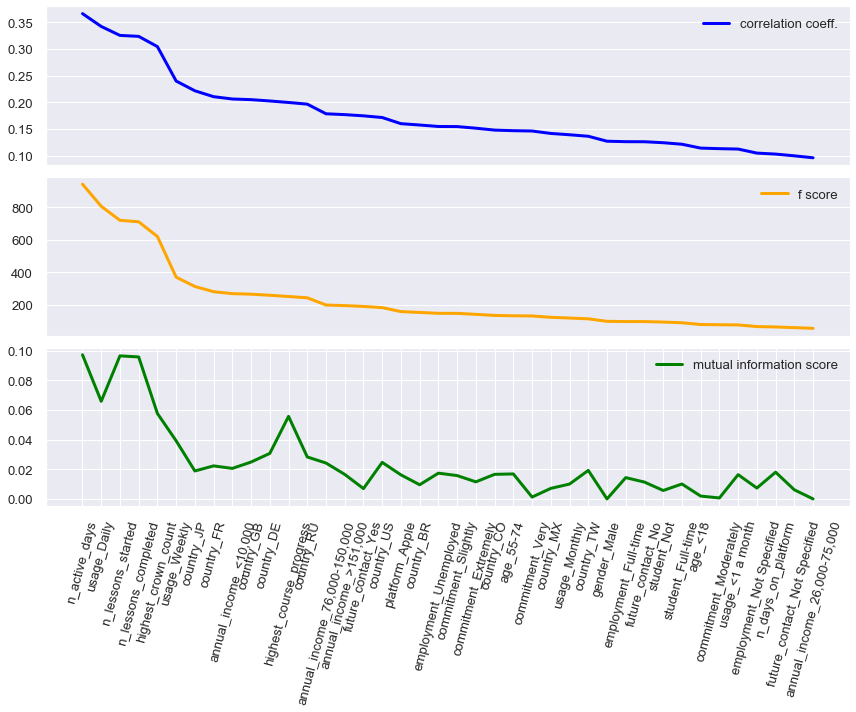

In [578]:
plt.rcParams["axes.grid"] = True
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(12,10))


axes[0].plot(cm_order2['purchased_subscription'][1:],color = "blue",label="correlation coeff.",linewidth = 3.0)
axes[0].set_xticks([])
axes[0].legend()

axes[1].plot(f_inorder.iloc[0],color = "orange",label="f score",linewidth=3.0)
axes[1].set_xticks([])
axes[1].legend()

axes[2].plot(mi_inorder.iloc[0],color = "green",label="mutual information score",linewidth=3.0)
axes[2].legend()


plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=75)
plt.tight_layout()
plt.show()

In [299]:
survey_usage_onehot

,daily_goal,highest_course_progress,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform,age_18-34,age_35-54,...,primary_language_proficiency_Beginner,primary_language_proficiency_Intermediate,primary_language_proficiency_Not Specified,student_Full-time,student_Not,student_Not Specified,student_Part-time,took_placement_test,purchased_subscription,survey_complete
0,19.0,23.0,38.0,3.0,32.0,30.0,2.0,2.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,1
1,30.0,4.0,7.0,3.0,32.0,31.0,3.0,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,False,0
2,19.0,21.0,38.0,3.0,25.0,25.0,3.0,2.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,False,1
3,35.0,2.0,1.0,2.0,12.0,5.0,1.0,2.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,1
4,50.0,12.0,54.0,3.0,467.0,401.0,4.0,2.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,41.0,38.0,332.0,86.0,291.0,293.0,6000.0,2381.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,True,1
6075,12.4,31.0,80.0,37.0,138.0,133.0,35.0,2382.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,1
6076,10.0,27.0,101.0,94.0,99.0,93.0,421.0,2389.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,True,1
6077,50.0,64.0,210.0,89.0,296.0,292.0,246.0,2400.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True,1


## Marketing Insights: Analyzing the Subscribing Users' Personas

In [308]:
le.transform(['Never', 'Yes', 'Previously', 'IDK'])

array([1, 3, 2, 0])

In [322]:
def if_retention(answer):
    if answer == 3:
        return 1
    else:
        return 0
# def if_retention(before, now):
#     if before == 1 and now != 1:
#         return ""
#     elif before == 0 and now == 1:
#         return 0
df['Retention'] = df['subscriber'].apply(if_retention)
df

,daily_goal,highest_course_progress,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform,age_18-34,age_35-54,...,primary_language_proficiency_Not Specified,student_Full-time,student_Not,student_Not Specified,student_Part-time,took_placement_test,purchased_subscription,survey_complete,subscriber,Retention
0,19.0,23.0,38.0,3.0,32.0,30.0,2.0,2.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,False,1,1,0
1,30.0,4.0,7.0,3.0,32.0,31.0,3.0,2.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,False,0,0,0
2,19.0,21.0,38.0,3.0,25.0,25.0,3.0,2.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,False,1,1,0
3,35.0,2.0,1.0,2.0,12.0,5.0,1.0,2.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,False,1,1,0
4,50.0,12.0,54.0,3.0,467.0,401.0,4.0,2.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,False,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6074,41.0,38.0,332.0,86.0,291.0,293.0,6000.0,2381.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,True,1,3,1
6075,12.4,31.0,80.0,37.0,138.0,133.0,35.0,2382.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,True,1,3,1
6076,10.0,27.0,101.0,94.0,99.0,93.0,421.0,2389.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,True,1,3,1
6077,50.0,64.0,210.0,89.0,296.0,292.0,246.0,2400.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,True,1,3,1


### Baseline Model: Logistic Regression--Existing Users

In [528]:
features = corrmat_index[1:41]
X = df[features]
y = df['purchased_subscription']
print(features)
num_feature = ['n_active_days', 'usage_Daily', 'n_lessons_started',
       'n_lessons_completed', 'highest_crown_count','highest_course_progress', 'n_days_on_platform']

Index(['n_active_days', 'usage_Daily', 'n_lessons_started',
       'n_lessons_completed', 'highest_crown_count', 'usage_Weekly',
       'country_JP', 'country_FR', 'annual_income_<10,000', 'country_GB',
       'country_DE', 'highest_course_progress', 'country_RU',
       'annual_income_76,000-150,000', 'annual_income_>151,000',
       'future_contact_Yes', 'country_US', 'platform_Apple', 'country_BR',
       'employment_Unemployed', 'commitment_Slightly', 'commitment_Extremely',
       'country_CO', 'age_55-74', 'commitment_Very', 'country_MX',
       'usage_Monthly', 'country_TW', 'gender_Male', 'employment_Full-time',
       'future_contact_No', 'student_Not', 'student_Full-time', 'age_<18',
       'commitment_Moderately', 'usage_<1 a month', 'employment_Not Specified',
       'n_days_on_platform', 'future_contact_Not Specified',
       'annual_income_26,000-75,000'],
      dtype='object')


In [531]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state = 1000,stratify = y)
# ss = StandardScaler(copy=True, with_mean=True, with_std=True)
# X_train[num_feature] = ss.fit_transform(X_train[num_feature])
# X_val[num_feature] = ss.transform(X_val[num_feature])

# for c in 1/np.logspace(-2,2,num=10):
#     model = LogisticRegression(penalty='l1',solver='saga',max_iter = 10000, multi_class='auto', C=c)
#     model.fit(X_train, y_train)
#     print("c=",c,"Train Acore: ", model.score(X_train, y_train),"Test Score: ",model.score(X_val, y_val))

In [535]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1000,stratify = y)
ss = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train[num_feature] = ss.fit_transform(X_train[num_feature])
X_test[num_feature] = ss.transform(X_test[num_feature])


le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1000,stratify = y)
ss = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train[num_feature] = ss.fit_transform(X_train[num_feature])
X_test[num_feature] = ss.transform(X_test[num_feature])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
param_grid = {'C': 1/np.logspace(-4,4,num=20)}

model = LogisticRegression(penalty='l1',solver='saga',max_iter = 10000, multi_class='auto')
grid1 = GridSearchCV(model, param_grid=param_grid,scoring = make_scorer(f1_score),
                    cv=kf, return_train_score = True)
grid1.fit(X_train, y_train)

print("Train F1 Score: ", grid1.score(X_train, y_train),"Val F1 Score: ",grid1.score(X_test, y_test))

Confusion Matrix

In [536]:
y_pred = grid1.predict(X_test)
# Confusion Matrix
cm_svc = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = cm_svc.ravel()
(tn, fp, fn, tp)

(892, 149, 114, 365)

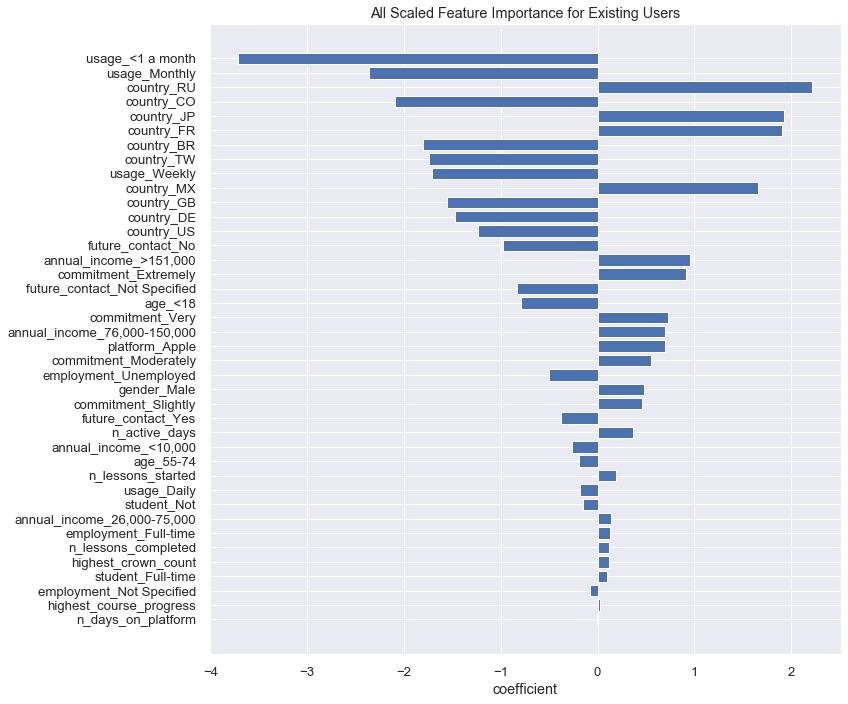

In [579]:
coefs = grid1.best_estimator_.coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.figure(figsize = (12,10))
plt.rcParams.update({'font.size': 14})
plt.barh(np.arange(40),coefs[sorted_indcs[-40:]])
plt.yticks(np.arange(40),features[sorted_indcs[-40:]])
plt.xlabel('coefficient')
plt.title('All Scaled Feature Importance for Existing Users')
plt.tight_layout()
plt.show()

### Baseline Model: Linear Regression--Potential Customer

In [557]:
features_potential = ['country_JP', 'country_FR', 'annual_income_<10,000', 'country_GB','country_DE','country_RU',
       'annual_income_76,000-150,000', 'annual_income_>151,000',
       'future_contact_Yes', 'country_US', 'platform_Apple', 'country_BR',
       'employment_Unemployed', 'commitment_Slightly', 'commitment_Extremely',
       'country_CO', 'age_55-74', 'commitment_Very', 'country_MX',
       'country_TW', 'gender_Male', 'employment_Full-time',
       'future_contact_No', 'student_Not', 'student_Full-time', 'age_<18',
       'commitment_Moderately', 'employment_Not Specified',
       'future_contact_Not Specified','annual_income_26,000-75,000','platform_Browser', 'survey_complete',
       'age_Not Specified', 'age_18-34', 'motivation_Challenge', 'commitment_Not', 'employment_Retired']
X = df[features_potential]
y = df['purchased_subscription']

In [504]:
len(features_potential)

37

In [505]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1000,stratify = y)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
param_grid = {'C': 1/np.logspace(-4,4,num=20)}

model = LogisticRegression(penalty='l1',solver='saga',max_iter = 10000, multi_class='auto')
grid2 = GridSearchCV(model, param_grid=param_grid,scoring = make_scorer(f1_score),
                    cv=kf, return_train_score = True)
grid2.fit(X_train, y_train)

print("Train F1 Score: ", grid2.score(X_train, y_train),"Val F1 Score: ",grid2.score(X_test, y_test))

Train F1 Score:  0.7069139966273187 Val F1 Score:  0.6958250497017894


In [558]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1000,stratify = y)
y_pred = grid2.predict(X_test)
# Confusion Matrix
cm_log = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = cm_log.ravel()
(tn, fp, fn, tp)

(864, 177, 129, 350)

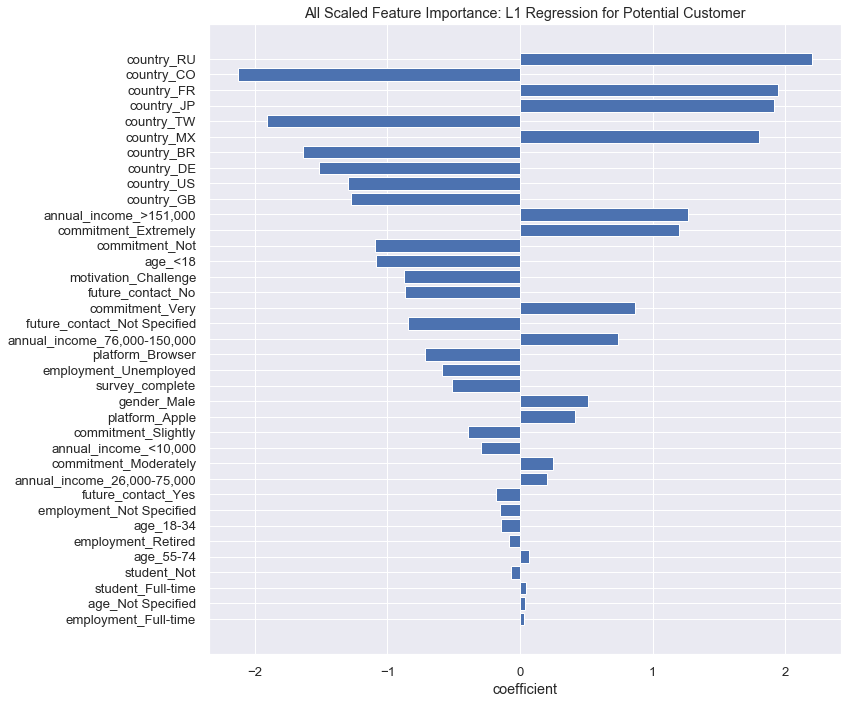

In [582]:
coefs = grid2.best_estimator_.coef_[0]
sorted_indcs = np.argsort(np.abs(coefs))

plt.figure(figsize = (12,10))
plt.rcParams.update({'font.size': 14})
plt.barh(np.arange(37),coefs[sorted_indcs[-37:]])
plt.yticks(np.arange(37),np.array(features_potential)[sorted_indcs[-37:]])
plt.xlabel('coefficient')
plt.title('All Scaled Feature Importance: L1 Regression for Potential Customer')
plt.tight_layout()
plt.show()

### Enhanced Model -- Existing Users

GradientBoosting: Catboost

In [507]:
# CatBoost

features = corrmat_index[1:41]
X = df[features]
y = df['purchased_subscription']
# print(features)
num_feature = ['n_active_days', 'usage_Daily', 'n_lessons_started',
       'n_lessons_completed', 'highest_crown_count','highest_course_progress', 'n_days_on_platform']

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1000,stratify = y)
ss = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train[num_feature] = ss.fit_transform(X_train[num_feature])
X_test[num_feature] = ss.transform(X_test[num_feature])

Iterations =  [50,100, 200, 400,800]
LearningRate = [0.01, 0.05,0.1,0.2,0.5]
Depth = [2, 3, 4, 5]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

CatBoostModel = catboost.CatBoostClassifier(logging_level='Silent')
HyperParams = dict(iterations=Iterations, learning_rate=LearningRate, depth=Depth)
GridSearchModel = GridSearchCV(CatBoostModel, HyperParams, cv=kf, scoring = make_scorer(f1_score))
GridSearchModel.fit(X_train, y_train)

print("Train F1 Acore: ", GridSearchModel.score(X_train, y_train),"Test F1 Score: ", GridSearchModel.score(X_test, y_test))

Train F1 Acore:  0.8357701462087725 Test F1 Score:  0.719758064516129


Support Vector Machine

In [513]:
from sklearn.svm import SVC

# SVC 
features = corrmat_index[1:41]
X = df[features]
y = df['purchased_subscription']
# print(features)
num_feature = ['n_active_days', 'usage_Daily', 'n_lessons_started',
       'n_lessons_completed', 'highest_crown_count','highest_course_progress', 'n_days_on_platform']

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1000,stratify = y)
ss = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train[num_feature] = ss.fit_transform(X_train[num_feature])
X_test[num_feature] = ss.transform(X_test[num_feature])


Gl = np.logspace(-5,0,20)
Cl = np.logspace(-3,4,20)
svcmodel = SVC(kernel = 'rbf', probability = True)
param_grid = {'gamma':Gl,"C":Cl}
Gridsvcmodel = GridSearchCV(svcmodel, param_grid, cv=kf, scoring = make_scorer(f1_score))
Gridsvcmodel.fit(X_train, y_train)

print("Train F1 Acore: ", Gridsvcmodel.score(X_train, y_train),"Test F1 Score: ", Gridsvcmodel.score(X_test, y_test))

Train F1 Acore:  0.7933461292386437 Test F1 Score:  0.7440982058545799


In [554]:
features = corrmat_index[1:41]
X = df[features]
y = df['purchased_subscription']
# print(features)
num_feature = ['n_active_days', 'usage_Daily', 'n_lessons_started',
       'n_lessons_completed', 'highest_crown_count','highest_course_progress', 'n_days_on_platform']

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1000,stratify = y)
ss = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train[num_feature] = ss.fit_transform(X_train[num_feature])
X_test[num_feature] = ss.transform(X_test[num_feature])

In [555]:
y_pred = Gridsvcmodel.predict(X_test)
# Confusion Matrix
cm_svc = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = cm_svc.ravel()
(tn, fp, fn, tp)

(855, 186, 85, 394)

In [515]:
# SAVE MODEL: SVC
sav = Gridsvcmodel.best_estimator_
pickle.dump(sav, open("svc.sav", 'wb'))

### Enhanced Model -- Potential Customers

In [510]:
# X = df[features_potential]
# y = df['purchased_subscription']
# le = LabelEncoder()
# y = le.fit_transform(y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1000,stratify = y)
# Iterations =  [50,100, 200, 400,800]
# LearningRate = [0.01, 0.05,0.1,0.2,0.5]
# Depth = [2, 3, 4, 5]
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)
# le = LabelEncoder()
# y = le.fit_transform(y)
# CatBoostModel = catboost.CatBoostClassifier(logging_level='Silent')
# HyperParams = dict(iterations=Iterations, learning_rate=LearningRate, depth=Depth)
# GridSearchModel2 = GridSearchCV(CatBoostModel, HyperParams, cv=kf, scoring = make_scorer(f1_score))
# GridSearchModel2.fit(X_train, y_train)

# print("Train F1 Acore: ", GridSearchModel2.score(X_train, y_train),"Test F1 Score: ", GridSearchModel2.score(X_test, y_test))

Train F1 Acore:  0.7232021709633651 Test F1 Score:  0.6970618034447822


In [518]:
# SVC
X = df[features_potential]
y = df['purchased_subscription']
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 1000,stratify = y)


Gl = np.logspace(-5,0,10)
Cl = np.logspace(-3,4,10)
svcmodel = SVC(kernel = 'rbf', probability = True)
param_grid = {'gamma':Gl,"C":Cl}
Gridsvcmodel2 = GridSearchCV(svcmodel, param_grid, cv=kf, scoring = make_scorer(f1_score))
Gridsvcmodel2.fit(X_train, y_train)

print("Train F1 Acore: ", Gridsvcmodel2.score(X_train, y_train),"Test F1 Score: ", Gridsvcmodel2.score(X_test, y_test))

Train F1 Acore:  0.7376253639598834 Test F1 Score:  0.6997084548104956


In [552]:
y_pred = Gridsvcmodel2.predict(X_test)
# Confusion Matrix
cm_svc = confusion_matrix(y_test,y_pred)
tn, fp, fn, tp = cm_svc.ravel()
(tn, fp, fn, tp)

(851, 190, 119, 360)

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

# model = RandomForestClassifier(n_estimators = 300)
# hyper_para = [[2,3,4,5,6],[1,3,5,7,9]]
# param_grid = {'max_depth':hyper_para[0],"max_features":hyper_para[1]}

# grid = GridSearchCV(model, param_grid=param_grid,scoring = make_scorer(accuracy_score),
#                     cv=kf, return_train_score = True)
# grid.fit(X_train, y_train)
# print("Train Acore: ", grid.score(X_train, y_train),"Val Score: ",grid.score(X_val, y_val))